# Lab-05: Visualizing tweets from the 2020 US presidential election

In [1]:
import os
import pandas as pd

# Dataset is a randomly sampled subset of: https://www.kaggle.com/manchunhui/us-election-2020-tweets
trump = pd.read_csv("2020_tweets_trump.csv", lineterminator='\n')
biden = pd.read_csv("2020_tweets_biden.csv", lineterminator='\n')

In [2]:
len(biden), len(trump)

(100000, 100000)

In [3]:
M = 10000
trump = trump.sample(n=M//2)
biden = biden.sample(n=M//2)

In [4]:
biden_tweets = biden['tweet'].tolist()
trump_tweets = trump['tweet'].tolist()

In [5]:
biden_tweets[3023]

'#Brit Harry Styles Endorses Joe #Biden, Says He’d Vote for Him If He\xa0Could https://t.co/AaXcr77tRi'

# Preprocessing pipeline

In [6]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    # http://emailregex.com/
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

/Users/jieyisun/opt/miniconda3/envs/TF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from tqdm import tqdm

with tqdm(total=M//2) as bar:
    for i, (bt, tt) in enumerate(zip(biden_tweets, trump_tweets)):
        biden_tweets[i] = pipeline(bt)
        trump_tweets[i] = pipeline(tt)
        bar.update()

100%|██████████| 5000/5000 [00:30<00:00, 166.11it/s]


In [8]:
biden_tweets[3023]

'brit harry styles endorses joe biden says he d vote him if he could aa xcr ri'

### Concatenate documents for vocab generation

In [9]:
all_tweets = biden_tweets + trump_tweets

## (20 pts) Task I: Train a Doc2Vec model (using the Gensim package) on tweets from the 2020 US presidential election

*Docs*: 

* https://radimrehurek.com/gensim/models/doc2vec.html

*Useful tutorials*: 

* https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

### Hyperparameters

In [10]:
# Change as needed
K = 20
word_frequency_threshold = 2
epochs = 10
lr = 0.01

In [21]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(vector_size=K, min_count=word_frequency_threshold, epochs=epochs)

In [22]:
# Your code goes here
import random
print(len(biden_tweets),len(trump_tweets))
all_tweets = biden_tweets + trump_tweets
#random.shuffle(all_tweets)
train_corpus =  all_tweets
print(len(all_tweets))

5000 5000
10000


In [23]:
import gensim
def read_corpus(corpus, tokens_only=False):
    for i, line in enumerate(corpus):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(corpus = train_corpus))
#test_corpus = list(read_corpus(corpus = test_corpus, tokens_only=True))
model.build_vocab(train_corpus)

In [24]:
model.train(train_corpus, total_examples=10000, epochs=epochs)

In [26]:
model.random.seed(0)
print(train_corpus[1])
vector = model.infer_vector(train_corpus[1][0])
print(vector)

TaggedDocument<['god', 'trumps', 'cheats', 'biden'], [1]>
[-0.0269018  -0.00276779  0.02372151 -0.00500377 -0.01859691 -0.01481028
  0.02435097  0.0293518  -0.06748983 -0.01662026  0.03048749 -0.01746273
 -0.00066745 -0.025753    0.05121411  0.00906669  0.02750314 -0.03214932
 -0.04351875 -0.01165922]


## (10  pts) Task II: Evaluate your model by computing the most similar documents (tweets) to new (perhaps made up) tweets

In [27]:
# Template function
def find_similar_tweets(tweet, top_n=10):
    doc_vector = model.infer_vector(tweet)
    sims = model.dv.most_similar([doc_vector], topn=top_n)
    return sims

In [29]:
# notice all_tweets = biden_tweets(5000) + trump_tweets(5000)
model.random.seed(1)
a = find_similar_tweets(['make', 'american', 'great', 'again'])  # Turmp's, similar should greater than 5000
print(a)
print(train_corpus[8048])
print(train_corpus[6693])
print(train_corpus[0][0])

[(7686, 0.8933108448982239), (9928, 0.8820940256118774), (6901, 0.8702609539031982), (7439, 0.8461072444915771), (3850, 0.8431937098503113), (7799, 0.8369275331497192), (3447, 0.8367157578468323), (2306, 0.8349646925926208), (2496, 0.8344326019287109), (9475, 0.8344240188598633)]
TaggedDocument<['we', 'trump', 'trumpisme', 'moeten', 'dat', 'amerikanen', 'trump', 'oz', 'va', 'rw'], [8048]>
TaggedDocument<['bnnvar', 'ed', 'nijpels', 'ozcan', 'akyol', 'np', 'alle', 'trump', 'no', 'kbi', 'unc', 'jr'], [6693]>
['bye', 'bye', 'trump', 'in', 'frndsder', 'joe', 'biden', 'kamala', 'harris', 'hope', 'india', 'with', 'arnab', 'relations']


## (10 pts extra credit) Task III: Produce a scatter plot of the compressed document embeddings (2D or 3D)

*Useful resources*:

* http://projector.tensorflow.org/

In [30]:
# Your code goes here
model.infer_vector(train_corpus[1][0])

array([-1.7277475e-02, -1.7524585e-02,  3.8846545e-02,  3.2958579e-03,
       -1.9474456e-02, -1.0784088e-06,  2.8960202e-02,  2.2147326e-02,
       -8.3515123e-02, -1.4149516e-02,  2.8761940e-02, -2.3388071e-02,
       -1.0610137e-02, -1.4615589e-02,  5.3849090e-02,  1.8392328e-02,
        3.4323309e-02, -2.9188463e-02, -3.8286172e-02, -1.8071318e-02],
      dtype=float32)

In [31]:
for i in train_corpus[0:8]:
    print(i)

TaggedDocument<['bye', 'bye', 'trump', 'in', 'frndsder', 'joe', 'biden', 'kamala', 'harris', 'hope', 'india', 'with', 'arnab', 'relations'], [0]>
TaggedDocument<['god', 'trumps', 'cheats', 'biden'], [1]>
TaggedDocument<['new', 'emails', 'from', 'biden', 'associate', 'tie', 'in', 'facebook', 'nq', 'big', 'tech', 'facebook', 'hunter', 'biden', 'joe', 'biden'], [2]>
TaggedDocument<['vote', 'trump', 'america', 'biden', 'build', 'back', 'better', 'all', 'biden', 'flipflop', 'biden', 'fracking', 'mag', 'ab', 'cn', 'cb', 'msnb', 'nb', 'cnb', 'oan', 'msnb', 'np', 'mr'], [3]>
TaggedDocument<['wie', 'stel', 'het', 'biden', 'trump'], [4]>
TaggedDocument<['you', 'lgbt', 'do', 'nt', 'bible', 'biden', 'cu', 'ta', 'yi', 'yn'], [5]>
TaggedDocument<['barackobama', 'yq', 'xiof'], [6]>
TaggedDocument<['class', 'joe', 'biden', 'kamala', 'harris', 'et'], [7]>


In [32]:
model.random.seed(10)
t = 0
b = 0

author = []
X = []
for i in train_corpus[3000:7000]: # draw part of courps
    model.random.seed(0)
    vec = model.infer_vector(i[0]).tolist()
    if i[1][0] < 5000:
        X.append(vec)
        b += 1
        author.append("biden")        
    elif i[1][0] >= 5000:
        X.append(vec)
        t += 1
        author.append("Biden")

print(t,b)
print(len(X))

2000 2000
4000


[ 21.971834 -24.255112  25.783852 ...  -9.639577  25.7403    -5.931903]


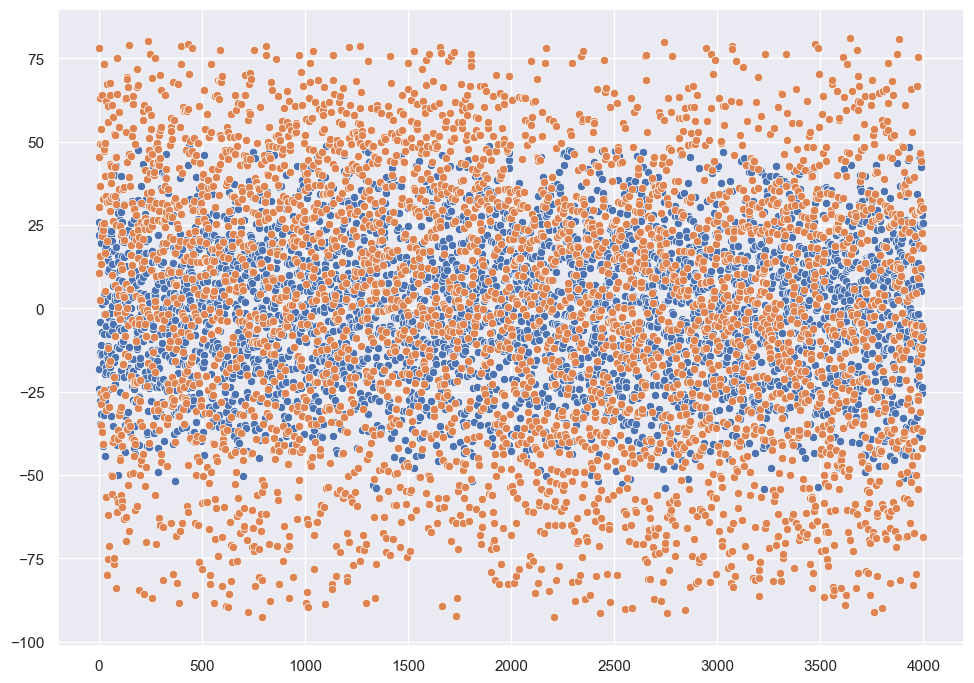

In [43]:
from matplotlib.font_manager import *  
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette( )
sns.scatterplot(X_tsne[:,0], legend='full') #blue 'biden'
sns.scatterplot(X_tsne[:,1], legend='full') #orange 'Biden'